In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.metrics import (accuracy_score, classification_report, 
                             precision_recall_curve, average_precision_score, 
                             roc_curve, auc, confusion_matrix, make_scorer, 
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline
plt.style.use('Solarize_Light2')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
inf_values = np.isinf(df)
inf_rows, inf_cols = np.where(inf_values)

nulls = df.isnull()
null_rows, null_cols = np.where(nulls)

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

print(f'Rows with null values: {null_rows.sum()}')
print(f'Columns with null values: {null_cols.sum()}')

print(f'Rows with inf values: {inf_rows.sum()}')
print(f'Columns with inf values: {inf_cols.sum()}')


Total of null data: 0
Total of duplicated data: 1081
Rows with null values: 0
Columns with null values: 0
Rows with inf values: 0
Columns with inf values: 0


In [4]:
duplicated_rows = df.duplicated()
duplicated_class_1_rows = duplicated_rows & (df['Class'] == 1)

print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')
print(f'Total duplicates of the Class 1: {duplicated_class_1_rows.sum()}')
print(f'Percentage of duplicates of Class 1: {duplicated_class_1_rows.sum() / df["Class"].sum() * 100:.1f}%')

# Eliminating duplicated data
df = df.copy().drop_duplicates()

Percentage of total duplicated data: 0.4%
Total duplicates of the Class 1: 19
Percentage of duplicates of Class 1: 3.9%


In [5]:
data_3_principal = df[['Time', 'Amount', 'Class']]
fraudulent_transactions = df[df['Class'] == 1]
not_fraudulent_transactions = df[df['Class'] == 0]

In [6]:
pf_3_variables = ProfileReport(data_3_principal, title='Report 3 principal variables', explorative=True)

pf_3_variables

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
print(f'Total data by class: {df["Class"].value_counts()}')

Total data by class: Class
0    283253
1       473
Name: count, dtype: int64


In [8]:
percentage_data_by_class = df['Class'].value_counts(normalize=True)
print(f'Percentage of data by class, (Imbalance): \n{percentage_data_by_class}')

Percentage of data by class, (Imbalance): 
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [9]:
corr = df.corr()

high_corr_pairs = []
correlation_value = 0.5
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= correlation_value:
            high_corr_pairs.append((corr.columns[i], corr.columns[j]))

print(f"Pairs of variables with a correlation greater than {correlation_value}:")
for pair in set(high_corr_pairs):
    print(pair)

Pairs of variables with a correlation greater than 0.5:
('Amount', 'V2')


In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


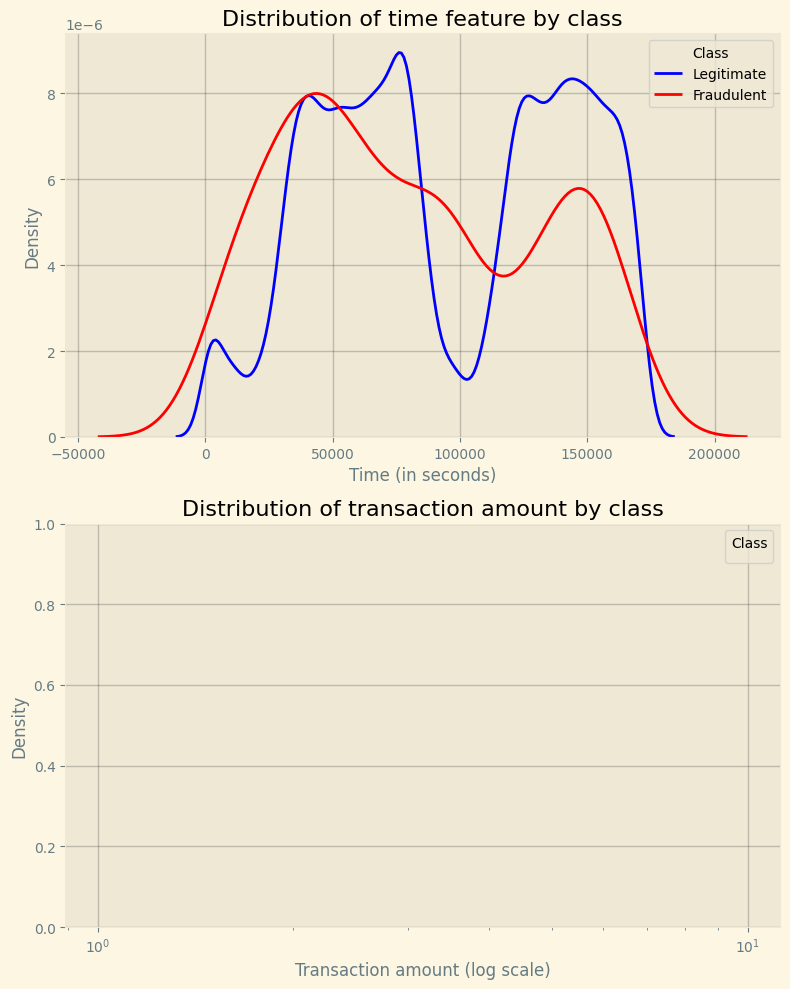

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))


sns.kdeplot(df[df['Class'] == 0]['Time'], color='blue', label='Legitimate', ax=axs[0])
sns.kdeplot(df[df['Class'] == 1]['Time'], color='red', label='Fraudulent', ax=axs[0])

axs[0].set_xlabel('Time (in seconds)')
axs[0].set_ylabel('Density')
axs[0].set_title('Distribution of time feature by class')
axs[0].legend(title='Class')
axs[0].grid(True, alpha=0.2, color='black')


axs[1].set_xscale('log') # Using a log scale for the x-axis
sns.kdeplot(df[df['Class'] == 0]['Amount'], color='blue', label='Legitimate', ax=axs[1])
sns.kdeplot(df[df['Class'] == 1]['Amount'], color='red', label='Fraudulent', ax=axs[1])

axs[1].set_title('Distribution of transaction amount by class')
axs[1].set_xlabel('Transaction amount (log scale)')
axs[1].set_ylabel('Density')
axs[1].legend(title='Class')
axs[1].grid(True, alpha=0.2, color='black')

plt.tight_layout()
plt.show()

In [12]:
def handle_imbalanced_data(dataset: pd.DataFrame, method: str='over_sampling', target_col: str='Class'):
    """
    Handle imbalanced data in a dataset.

    Parameters:
    dataset (DataFrame): The input dataset which is imbalanced.
    method (str): The method to handle imbalanced data. It can be 'over_sampling', 'under_sampling', 'smote'. Default is 'over_sampling'.
    target_col (str): The name of the target variable column. Default is 'Class'.

    Returns:
    DataFrame: The balanced dataset.
    """
    # Counts of each class
    count_class_0, count_class_1 = dataset[target_col].value_counts()

    # Dividing the dataset by class
    df_class_0 = dataset[dataset[target_col] == 0]
    df_class_1 = dataset[dataset[target_col] == 1]

    # Oversampling: Oversample 1-class and concat the DataFrames of both classes
    if method == 'over_sampling':
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        return pd.concat([df_class_0, df_class_1_over], axis=0)

    # Undersampling: Undersample 0-class and concat the DataFrames of both classes
    elif method == 'under_sampling':
        df_class_0_under = df_class_0.sample(count_class_1)
        return pd.concat([df_class_0_under, df_class_1], axis=0)

    # SMOTE: Using SMOTE to deal with the imbalanced data
    elif method == 'smote':
        smote = SMOTE(random_state=42)
        X = dataset.drop(target_col, axis=1)
        y = dataset[target_col]
        X_sm, y_sm = smote.fit_resample(X, y)
        X_sm_df, y_sm_df = pd.DataFrame(X_sm, columns=X.columns), pd.DataFrame(y_sm, columns=[target_col])
        df_sm = pd.concat([X_sm_df, y_sm_df], axis=1)
        return df_sm

    else:
        raise ValueError("Invalid method. It should be 'over_sampling', 'under_sampling', 'smote' ... ")

In [13]:
for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df, method=method, target_col='Class')
    class_counts = balanced_data['Class'].value_counts()
    print(f'Balanced data using {method} method: \n{class_counts}\n')

Balanced data using over_sampling method: 
Class
0    283253
1    283253
Name: count, dtype: int64

Balanced data using under_sampling method: 
Class
0    473
1    473
Name: count, dtype: int64

Balanced data using smote method: 
Class
0    283253
1    283253
Name: count, dtype: int64



In [14]:
# Scaler to use
scaler = RobustScaler()

# Scaling the 'Amount' and 'Time' columns and dropping its original columns
df_scaled = df.copy()
df_scaled[['Amount_normalized', 'Time_normalized']] = scaler.fit_transform(df[['Amount', 'Time']])

df_scaled.drop(['Amount', 'Time'], axis=1, inplace=True)
df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_normalized,Time_normalized
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,...,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,0.001667,0.924387,0.118912
std,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,...,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,0.040796,3.482123,0.557988
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,-0.305938,-0.995290
25%,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,...,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,0.000000,-0.228063,-0.358286
50%,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,...,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,0.000000,0.000000,0.000000
75%,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,...,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,0.000000,0.771937,0.641714
max,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000,356.962314,1.035329


In [ ]:
after_parameters = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 
                    'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 
                    'class_weight': 'balanced_subsample', 'bootstrap': False}

model = RandomForestClassifier(**after_parameters, random_state=42)

for method in ['over_sampling', 'under_sampling', 'smote']:
    balanced_data = handle_imbalanced_data(df_scaled, method=method)
    X = balanced_data.drop('Class', axis=1)
    y = balanced_data['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification report for {method} and {model.__class__.__name__}: \n{classification_report(y_test, y_pred)}")
    print('\n')

Classification report for over_sampling and RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84888
           1       1.00      0.91      0.95     85064

    accuracy                           0.95    169952
   macro avg       0.96      0.95      0.95    169952
weighted avg       0.96      0.95      0.95    169952



Classification report for under_sampling and RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       140
           1       0.99      0.92      0.95       144

    accuracy                           0.95       284
   macro avg       0.96      0.95      0.95       284
weighted avg       0.96      0.95      0.95       284





In [ ]:

balanced_data = handle_imbalanced_data(df_scaled, method='under_sampling')
X = balanced_data.drop('Class', axis=1)
y = balanced_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Correlation matrix
corr_under_sampling = balanced_data.corr()

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_under_sampling, annot=True, fmt=".1f") # Heatmap with correlations

plt.tight_layout()
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

corr_smote = balanced_data.corr()

# Filtering correlations
high_corr_pairs = []
correlation_value = 0.7
for i in range(len(corr_smote.columns)):
    for j in range(i):
        if abs(corr_smote.iloc[i, j]) >= correlation_value:
            high_corr_pairs.append((corr_smote.columns[i], corr_smote.columns[j]))

print(f'Number of pairs with correlations greater than {correlation_value}: {len(set(high_corr_pairs))}')

In [ ]:
# Parameter grid to search best parameters
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [1, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

rf = RandomForestClassifier() # Classifier

# Using k-fold cross-validation to split the data and starting the search
cv = StratifiedKFold(n_splits=3)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, cv=cv, n_jobs=-1, n_iter=10)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_

# Training the model using the best parameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train) # Predictions on the training set
y_test_pred = best_model.predict(X_test) # Predictions on the test set

train_accuracy = accuracy_score(y_train, y_train_pred) # Training accuracy
test_accuracy = accuracy_score(y_test, y_test_pred) # Test accuracy
  
roc_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"ROC AUC Score: {roc_auc}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print(f"Classification report for {best_model.__class__.__name__}: \n{classification_report(y_test, y_test_pred)}")
print('Best params:', best_params)

In [ ]:
'''from joblib import dump

dump(best_model, 'user/bhairabmahato/py/best_model-credit-card-fraud.joblib') 

In [ ]:
# Lists to store accuracies
train_accuracies = []
test_accuracies = []

for i in range(20):
    best_model_20_runs = RandomForestClassifier(**best_params, random_state=i)
    best_model_20_runs.fit(X_train, y_train)
    
    y_train_pred = best_model_20_runs.predict(X_train) # Predictions on the training set
    y_test_pred = best_model_20_runs.predict(X_test) # Predictions on the test set

    train_accuracy = accuracy_score(y_train, y_train_pred) # Training accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred) # Test accuracy

    # Appending accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 21), y=train_accuracies, marker='o', label='Train Accuracy')
sns.lineplot(x=range(1, 21), y=test_accuracies, marker='o', label='Test Accuracy')
plt.title('Train and Test Accuracy over 20 Runs')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True, alpha=0.2, color='black')

# Add a note
plt.text(1, 0.92, 'Note: The y-axis is not scaled from 0 to 1\nfor a better visualization of the differences', 
         bbox=dict(facecolor='red', alpha=0.5))

plt.show()

In [ ]:
# Defining the metrics to analyze
metrics = {
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score),
    'ROC AUC': make_scorer(roc_auc_score)
}

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel() # Flattening the 2D array

# For each metric
for i, (metric_name, metric) in enumerate(metrics.items()):
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(best_model, 
                                                            X_train, 
                                                            y_train,
                                                            cv=StratifiedKFold(n_splits=3),
                                                            scoring=metric,
                                                            n_jobs=-1, 
                                                            train_sizes=np.linspace(0.01, 1.0, 50))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    axs[i].plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    axs[i].plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    axs[i].set_title(f"Learning curve ({metric_name})")
    axs[i].set_xlabel("Training Set Size")
    axs[i].set_ylabel(metric_name)
    axs[i].legend(loc="best")
    axs[i].grid(True, alpha=0.2, color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Computing precision-recall pairs for different probability thresholds
y_score = best_model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_score)

# Plotting Precision-Recall curve
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.4, color='black')

# Computing the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.subplot(1,3,2)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, ROC Curve')
plt.grid(True, alpha=0.2, color='black')
plt.legend(loc="lower right")

# Computing the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plotting Confusion Matrix
plt.subplot(1,3,3)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.grid(True, alpha=0.2, color='black')
plt.tight_layout()
plt.show()

# Area under the precision-recall curve
print('Area under the precision-recall curve: {0:0.2f}'.format(roc_auc))

# Computing the average precision score
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))